In [84]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf


# Problem Statement

As a newbie mobile dev, I would like to understand the market and find out how to make money from app development.

I want to look at various views
* Percentage between free vs paid apps across categories. 
* Price tier for each categories

* Then how much money I can make from that category, gendre

Then I would like to ask 
* Predict Rating base on Reviews / Installs / Price

The core of this presentation is to build a model / correlation between features vs rating. 
It should some how address the question, 
* What is the optimum price tier for app to receive more reviews and higher rating?
* What is the optimum app size to receive more reviews and higher rating?
* For paid apps only, what are interesting facts about them?

## Review the data

In [85]:
df = pd.read_csv('google-play-store-apps/googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [86]:
# keep one sample data for testing
df_test = df[df['App'] == 'Monash Uni Low FODMAP Diet'].head(1).copy()
df_test

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2243,Monash Uni Low FODMAP Diet,MEDICAL,4.2,1135,12M,"100,000+",Paid,$9.00,Everyone,Medical,"July 16, 2018",2.0.7,4.0 and up


# Cleaning data

In [87]:
# clean the data
df.drop_duplicates(subset='App', inplace=True)
df = df[~df['Android Ver'].isna()]

print('Number of apps in the dataset: ', len(df))
df.sample(5)

Number of apps in the dataset:  9657


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2326,MyQuest for Patients,MEDICAL,4.0,3803,16M,"100,000+",Free,0,Everyone,Medical,"March 13, 2018",2.17,4.0 and up
7204,TI-84 CE Graphing Calculator Manual TI 84,FAMILY,5.0,1,27M,100+,Paid,$4.99,Everyone,Education,"March 28, 2018",1.5.2,4.1 and up
9647,The EO Bar,HEALTH_AND_FITNESS,4.7,416,34M,"10,000+",Paid,$6.99,Everyone,Health & Fitness,"July 2, 2018",1.3.7,4.1 and up
6708,Next Portuguese(BR) Langpack,TOOLS,4.3,1320,778k,"100,000+",Free,0,Everyone,Tools,"September 13, 2013",1.0,2.0 and up
629,chat live chat,DATING,NaN,24,3.9M,"1,000+",Free,0,Mature 17+,Dating,"July 26, 2018",1.0,4.0 and up


In [88]:
# Remove + and , sign then convert to integer
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', ''))
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', ''))
df['Installs'] = df['Installs'].apply(lambda x: int(x))

In [89]:
# Convert to integer
df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

In [90]:
# Convert to float
df['Price'] = df['Price'].apply(lambda x: x.replace('$', ''))
df['Price'] = df['Price'].apply(lambda x: float(x))

In [91]:
df['Size'] = df['Size'].apply(lambda x: x.replace('Varies with device', 'NaN'))
df['Size'] = df['Size'].apply(lambda x: x.replace('M', ''))
df['Size'] = df['Size'].apply(lambda x: float(x.replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(x))

In [92]:
df_clean = df.copy()
df_clean['Rating'].dropna(inplace=True)
df_clean['Size'].dropna(inplace=True)

df_clean = df_clean[df_clean['Installs'] > 0]
df_clean['Installs'].dropna(inplace=True)
df_clean['Installs_Log'] = np.log(df_clean['Installs'])

df_clean = df_clean[df_clean['Reviews'] > 0]
df_clean['Reviews'].dropna(inplace=True)
df_clean['Reviews_Log'] = np.log(df_clean['Reviews'])

df_clean['Type'].dropna(inplace=True)

In [211]:
# some testing
df_assert = df_clean[df_clean['App'] == 'Monash Uni Low FODMAP Diet']
assert(df_assert['Rating'].item() == df_test['Rating'].item())
assert(df_assert['Reviews'].item() == 1135)
assert(df_assert['Size'].item() == 12.0)
assert(df_assert['Installs'].item() == 100000) 
assert(df_assert['Type'].item() == 'Paid')

# EDA

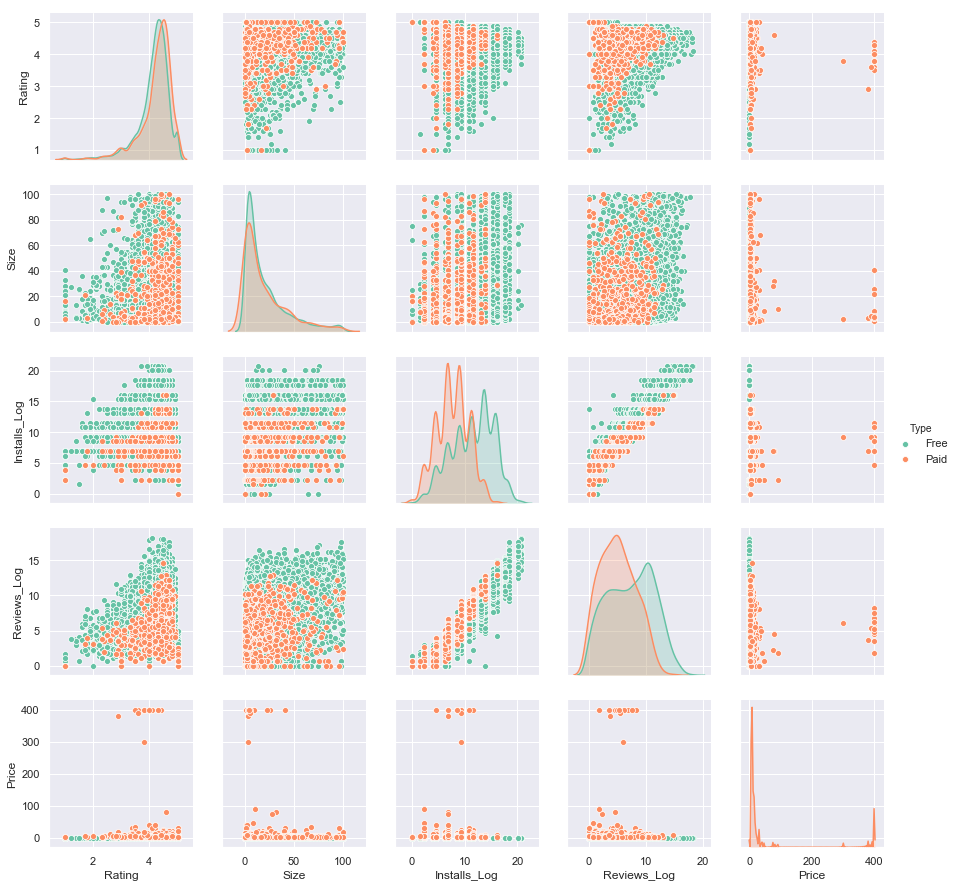

In [127]:
sns.pairplot(data=df_clean[['Rating', 
                            'Size', 
                            'Installs_Log', 
                            'Reviews_Log', 
                            'Type', 
                            'Price']], hue='Type', palette='Set2')

## Breakdown by categories

Looking at categories, I can see that Family, Games and Tools categories accounts for 40% of the dataset. However, this is not necessary the same for the whole market.

* Family accounts for 20% total apps
* Game and Tools follow with ~10% each

That means there are lot of demands and competitions in these categories.

In [79]:
apps_category = df_clean['Category'].value_counts()
data = [go.Pie(
    labels = apps_category.index,
    values = apps_category.values,
    hoverinfo = 'label+value'
)]

plotly.offline.iplot(data)

## Overall Ratings

Let take a look at app ratings.

In [80]:
print('Average rating of apps: ', df_clean['Rating'].mean())

Average rating of apps:  4.173175494264096


It's a bit suprise that the average app rating is 4.1 - quite high. That also means if I want to make my app standout of the crowd, it much be higher than this, probably >= 4.3 

In [81]:
data = [go.Histogram(
    x = df_clean['Rating'],
    xbins = {'start': 1, 'size': 0.1, 'end': 5}
)]
plotly.offline.iplot(data)

## Categories vs Rating

Now I would like to look deeper into each category to see their average rating. 

In [192]:
groups = df_clean.groupby('Category').filter(lambda x: len(x) > 200).reset_index()

layout = {
    'title': 'App rating across major categories',
    'xaxis': { 'tickangle': -40 },
    'yaxis': { 'title': 'Rating' },
    'plot_bgcolor': 'rgb(250, 250, 250)'
}

data = []
for i, category in enumerate(list(set(groups.Category))):
    data.append({'y': df_clean.loc[(df_clean.Category == category) & (df_clean.Type == 'Free')]['Rating'],
                 'type': 'violin',
                 'name': category,
                 'side': 'positive',
                 'showlegend': True,
                 'meanline': { "visible": True } })
    data.append({'y': df_clean.loc[(df_clean.Category == category) & (df_clean.Type == 'Paid')]['Rating'],
                 'type': 'violin',
                 'name': category,
                 'side': 'negative',
                 'showlegend': True,
                 'meanline': { "visible": True } })

plotly.offline.iplot({'data': data, 'layout': layout})

**Finding**: The average rating across apps are quite the same. However, there are a clear distinction between Free Apps vs Paid Apps in the Magazine categories. 

Whare are those Paid Apps?

In [215]:
df_clean[(df_clean['Category'] == 'NEWS_AND_MAGAZINES') & (df_clean['Type'] == 'Paid')]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_Log,Reviews_Log
4491,"Q Alerts: QAnon Drop Notifications, Research +++",NEWS_AND_MAGAZINES,4.7,143,26.0,5000,Paid,0.99,Mature 17+,News & Magazines,"July 26, 2018",4.1.10,4.1 and up,8.517193,4.962845
9828,Égalité et Réconciliation,NEWS_AND_MAGAZINES,4.9,58,3.8,500,Paid,2.99,Everyone,News & Magazines,"May 26, 2018",1.1.1,5.0 and up,6.214608,4.060443


# Size vs Rating

* Most of apps are less than 10 MB
* Highest rating apps - close to 5 - are also less than 20 MB

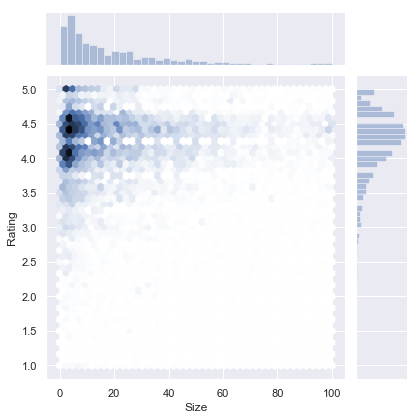

In [136]:
sns.jointplot(df_clean['Size'], df_clean['Rating'], kind='hex')

## Price vs Rating

In [19]:
df_clean['Price_Type'] = 0
df_clean.loc[df_clean['Type'] == 'Paid', 'Price_Type'] = 1
df_price_type = df_clean.groupby('Category')[['Price_Type', 'App']]\
                        .agg({'App': 'count', 'Price_Type': 'sum'}, as_index=False)\
                        .rename(columns={'App': 'Count', 'Price_Type': 'Paid_Count'})

df_price_type['Perc_Paid'] = np.round(100 * df_price_type['Paid_Count'] / df_price_type['Count'], 2)
df_price_type['Perc_Free'] = 100 - df_price_type['Perc_Paid']
df_price_type['Total'] = 100
df_price_type.reset_index(inplace=True)
df_price_type = df_price_type[df_price_type['Count'] > 200]
df_price_type = df_price_type.sort_values(by=['Perc_Paid', 'Count'], ascending=[False, False])
df_price_type.head()

,Category,Count,Paid_Count,Perc_Paid,Perc_Free,Total
20,MEDICAL,333,75,22.52,77.48,100
23,PERSONALIZATION,343,70,20.41,79.59,100
11,FAMILY,1762,169,9.59,90.41,100
29,TOOLS,784,70,8.93,91.07,100
6,COMMUNICATION,286,24,8.39,91.61,100


In [132]:
paid_apps = go.Bar(
    x=df_price_type['Category'],
    y=df_price_type['Perc_Paid'],
    name='% Paid Apps'
)
free_apps = go.Bar(
    x=df_price_type['Category'],
    y=df_price_type['Perc_Free'],
    name='% Free Apps'
)

data = [paid_apps, free_apps]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [130]:
total_apps = go.Bar(
    x=df_price_type['Category'],
    y=df_price_type['Count'],
    name='Total Apps'
)
paid_apps = go.Bar(
    x=df_price_type['Category'],
    y=df_price_type['Paid_Count'],
    name='Paid Apps'
)

data = [total_apps, paid_apps]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

## Installs vs Rating

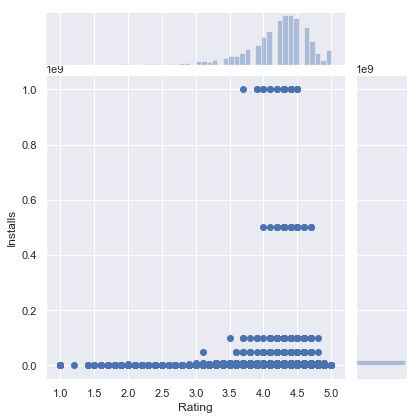

In [194]:
sns.jointplot(x='Rating', y='Installs', data=df_clean)

**Finding**: We can see that popular apps with more intalls are more likely to receive higher ratings than apps with less downloads. Those apps are super apps and communications apps from big companies like Google, Facebook, ...

In [199]:
df_clean[df_clean['Installs'] >= 1e9].sort_values(by=['Rating'], ascending=False).head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_Log,Reviews_Log
2545,Instagram,SOCIAL,4.5,66577313,NaN,1000000000,Free,0.0,Teen,Social,"July 31, 2018",Varies with device,Varies with device,20.723266,18.013874
2808,Google Photos,PHOTOGRAPHY,4.5,10858556,NaN,1000000000,Free,0.0,Everyone,Photography,"August 6, 2018",Varies with device,Varies with device,20.723266,16.200464
1654,Subway Surfers,GAME,4.5,27722264,76.0,1000000000,Free,0.0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up,20.723266,17.137746
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,NaN,1000000000,Free,0.0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device,20.723266,18.051345
3234,Google,TOOLS,4.4,8033493,NaN,1000000000,Free,0.0,Everyone,Tools,"August 3, 2018",Varies with device,Varies with device,20.723266,15.899130


## Installs vs Reviews

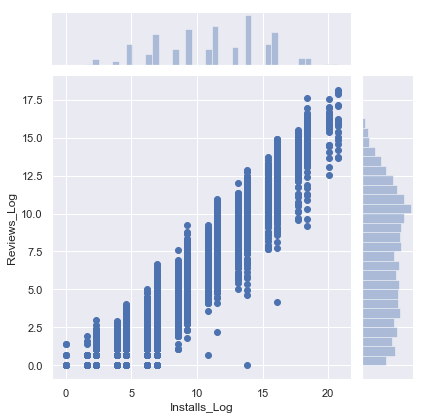

In [201]:
sns.jointplot(x='Installs_Log', y='Reviews_Log', data=df_clean)

**Finding**: The correlation between Installs and Reviews is quite clear. The more downloads an app has, the more Reviews it might get.

## Predictions

Now let see the correlation between major features including: Rating, Size, Installs, Reviews and Price.

In [158]:
df_model = df_clean[['Rating', 'Size', 'Installs_Log', 'Price', 'Reviews_Log']]
df_model = df_model.dropna(how='any')

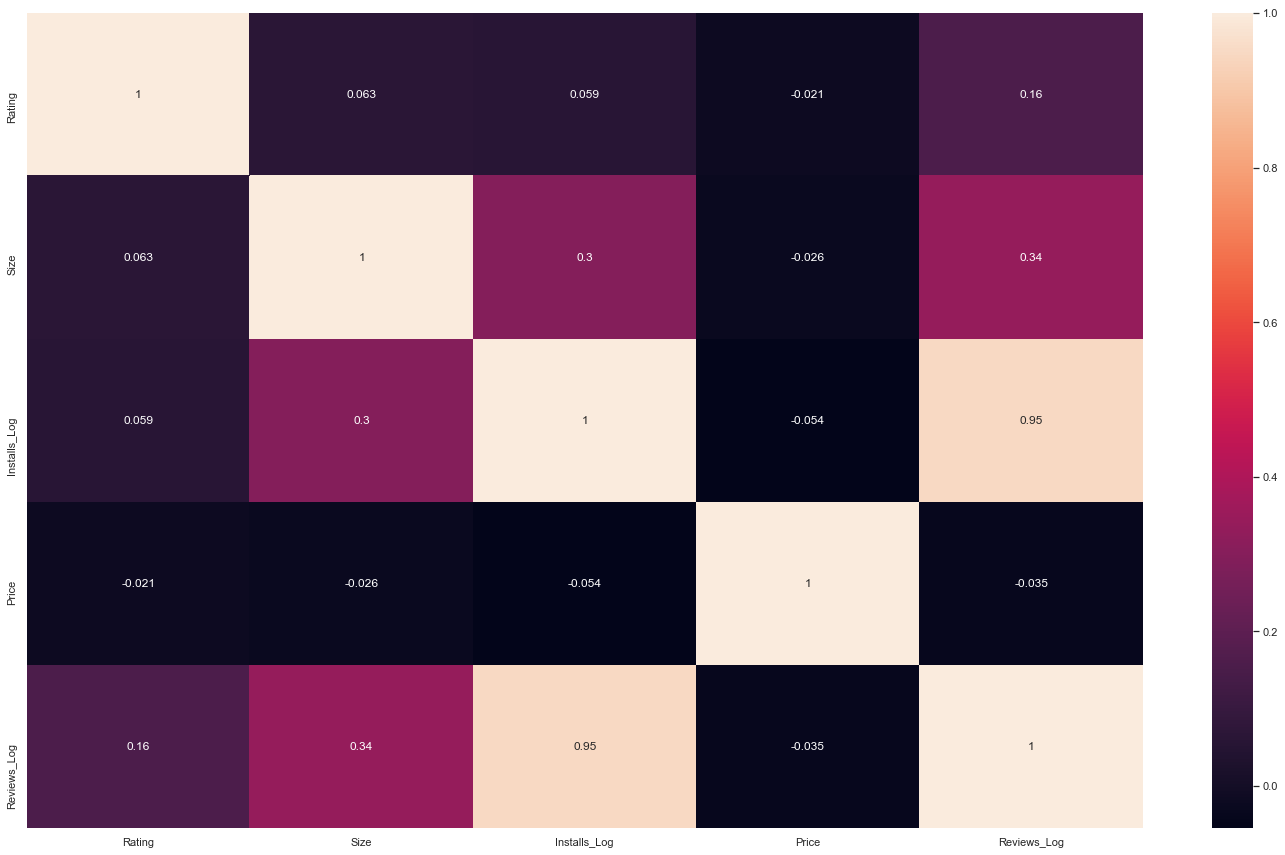

In [159]:
corr = df_model.corr()
sns.heatmap(corr, annot=True)

**Finding** 
* Again this matrix show a strong correlation between Installs and Reviews. 
* Furthermore, Rating is positively correlated with Installs, Reviews, Size

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [208]:
X = df_model.drop(columns=['Rating'])
y = df_model['Rating']

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

l_model = LinearRegression()
l_model.fit(X_train, y_train)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred_l = l_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

In [210]:
print('MSE for Linear Regression', metrics.mean_squared_error(y_test, y_pred_l))
print('MSE for Random Forest', metrics.mean_squared_error(y_test, y_pred_rf))

MSE for Linear Regression 0.28597803646104
MSE for Random Forest 0.3642116431034043


**Conclusion**: 
* Both models' MSE are still high. They so simple to predict rating from basic features. 